### Exploratory Data Analysis

Before modeling, let's explore the data to see how many images we have and how many faces we have to build our model with. Next we will create a dataframe for easier image reference. Then we will check a few images with annotations to make sure they are reading in correctly.

In [3]:
# import the necessary packages
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd

In [4]:
# create file paths for easy reference
image_path= pathlib.Path('/Users/alexander.fioto/datasets/mask-detection/images/')
annot_path = pathlib.Path('/Users/alexander.fioto/datasets/mask-detection/annotations/')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
label_directories = sorted(glob.glob(os.path.join(annot_path, "*.xml")))

In [5]:
image_directories[0]

'/Users/alexander.fioto/datasets/mask-detection/images/maksssksksss0.png'

In [17]:
# maximum number of objects will determine columns needed for dataframe
face_count = []
for file in os.listdir(annot_path):
    xml = et.parse(os.path.join(annot_path, file)) 
    root = xml.getroot()
    face_count.append(len(root) - 4)

print("Total number of images: ", len(os.listdir(annot_path)))
print("Maximum # of objects per image: ", max(face_count))
print("Miniumum # of objects per image: ", min(face_count))
print("Average # of objects per image: ", round(np.mean(face_count),1))

Total number of images:  853
Maximum # of objects per image:  115
Miniumum # of objects per image:  1
Average # of objects per image:  4.8


In [18]:
# check total number of labels per class
label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}

for file in os.listdir(annot_path):

    xml = et.parse(os.path.join(annot_path, file)) 
    root = xml.getroot()    

    for i in range(4,len(root)):
        label_dict[root[i][0].text] += 1

print("Faces with mask: ", label_dict['with_mask'])
print("Faces without mask: ", label_dict['without_mask'])
print("Faces with mask worn incorrectly: ", label_dict['mask_weared_incorrect'])

Faces with mask:  3232
Faces without mask:  717
Faces with mask worn incorrectly:  123


In [19]:
# reference: https://docs.python.org/3/library/xml.etree.elementtree.html
# Creating a dictionary that can be used in a dataframe
image_dict = {"image": [],"Dimensions": [], "face_count": []}
# 115 is the max number of faces per image
for i in range(1,116):
    image_dict[f'Object {i}']=[]

# loop through annotation files to parse object information
for file in sorted(os.listdir(annot_path)):
    row = []
    xml = et.parse(os.path.join(annot_path, file)) 
    root = xml.getroot()
    # extract image name and add to start of row
    img = root[1].text
    row.append(img)
    # extract image dimensions
    h,w = root[2][0].text,root[2][1].text
    row.append([h,w])
    face_ct = len(root) - 4
    row.append(face_ct)
    
    
    # add column to each row for each object (face). Objects start at the 4th element
    for i in range(4,len(root)):
        temp = []
        # object label - with_mask, without_mask, or mask_weared_incorrect
        temp.append(root[i][0].text)
        # bounding box dimensions
        for point in root[i][5]:
            temp.append(point.text)
        row.append(temp)
    # after appending all objects to row, add a 0 for remainder
    for i in range(len(row),119):
        row.append(0)
        
    # add all elements to the dictionary
    for i,each in enumerate(image_dict):
        image_dict[each].append(row[i])
df = pd.DataFrame(image_dict)

In [20]:
df.head()

,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]",3,"[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]",9,"[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]",1,"[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]",3,"[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]",1,"[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def show_annotated_image(image):
    
    """This function adds annotation labels and bounding boxes to each image
    so that we can display ground truth images with annotations"""
    
    row = df[df['image'] == image]
    idx = row.index
    
    new_image_path = os.path.join(image_path,image)
    
    original_image = cv2.imread(new_image_path)
    
    for obj in row.columns[3:]:
        info = row[obj][idx]
        if info.any():
            label_name = info.iloc[0][0]
            coordinates = info.iloc[0][1:]

            if label_name == 'with_mask':
                label = 'with_mask'
                color = (0, 255, 0)
            elif label_name == 'without_mask':
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            
            coordinates = [int(pt) for pt in coordinates]

            cv2.rectangle(
                original_image,
                (coordinates[0], coordinates[1]),
                (coordinates[2], coordinates[3]),
                color,
                2
            )
            cv2.putText(original_image, label, (coordinates[0], coordinates[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)) 
    plt.grid(None)

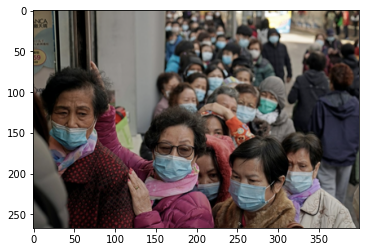

In [25]:
# display original image
test_image_path = os.path.join(image_path,'maksssksksss11.png')
test_image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB));

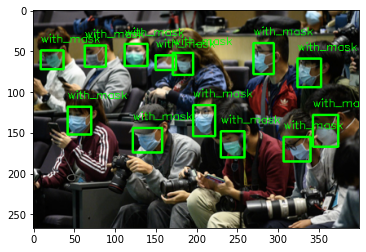

In [26]:
# display annotated image
show_annotated_image('maksssksksss247.png')
plt.grid(None)

In [27]:
# pickle the image dataframe for future reference
df.to_pickle('image_df.pkl')

In [10]:
# --break - remove all below --

In [66]:
new_df = pd.read_pickle('image_df.pkl')
new_df

,image,Dimensions,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,Object 8,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]","[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]","[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]","[with_mask, 369, 70, 398, 99]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]","[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]","[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]","[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,maksssksksss95.png,"[301, 400]","[without_mask, 67, 289, 155, 400]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
849,maksssksksss96.png,"[400, 280]","[with_mask, 102, 97, 140, 135]","[without_mask, 64, 151, 110, 201]","[without_mask, 251, 88, 282, 124]","[with_mask, 296, 153, 335, 195]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
850,maksssksksss97.png,"[301, 400]","[with_mask, 187, 83, 212, 109]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
851,maksssksksss98.png,"[400, 267]","[with_mask, 196, 43, 236, 91]","[with_mask, 41, 73, 65, 95]","[with_mask, 263, 62, 287, 85]","[with_mask, 344, 80, 377, 106]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
j=0
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

print("Extracting each data into respective label folders....")
for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            # first element of the "object" cell - replace label with the index from classes list
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            if((info[3]-info[1])>15 and (info[4]-info[2])>15):
                try:
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    data.append(face)
                    labels.append(label)
                    if(label=="mask_weared_incorrect"):
                        data.append(face)
                        labels.append(label)

                except:
                    pass

print("Done!")

Extracting each data into respective label folders....
Done!


In [13]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels[:10]

array(['with_mask', 'without_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask'],
      dtype='<U21')

In [14]:
len(labels)

2061

In [15]:
model_label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}

for i in labels:
    model_label_dict[i] += 1

print("Total per label for model use: ", model_label_dict)

Total per label for model use:  {'with_mask': 1632, 'without_mask': 311, 'mask_weared_incorrect': 118}


### Prep for Modeling

- encode labels
- train test split
- image augmentation

In [16]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [17]:
lb.classes_

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype='<U21')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20,
                                                   stratify=labels, random_state = 22)

In [19]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Model

In [20]:
# Set initial parameters
INIT_LR = .0005
EPOCHS = 50
BS = 96

In [21]:
# load base model with imagenet pre-trained weights
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [27]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [28]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process. This way, only the
# head layers are adjusted during back propogation
for layer in baseModel.layers:
    layer.trainable = False

In [29]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
    verbose=0)

[INFO] compiling model...
[INFO] training head...


In [41]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [30]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,
    target_names=lb.classes_))


[INFO] evaluating network...
                       precision    recall  f1-score   support

mask_weared_incorrect       0.70      0.58      0.64        24
            with_mask       0.95      0.96      0.96       327
         without_mask       0.83      0.84      0.83        62

             accuracy                           0.92       413
            macro avg       0.83      0.79      0.81       413
         weighted avg       0.92      0.92      0.92       413



In [43]:
cm = tensorflow.math.confusion_matrix(y_test.argmax(axis=1), predictions=predIdxs)

In [59]:
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)

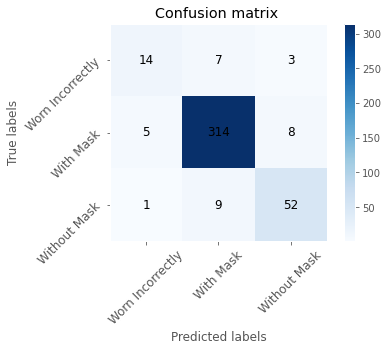

In [72]:
# Aid from: https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
plt.yticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
plt.grid(None)
plt.title('Confusion matrix ')
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', size='large')
plt.show()

In [ ]:
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

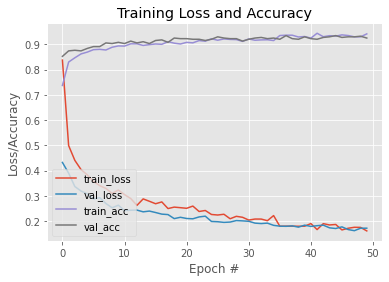

In [26]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [27]:
predIdxs

array([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,

In [28]:
model.save('model1.h5')

In [30]:
face_path = pathlib.Path('/Users/claireph/DSI/large-data/face-mask-detector/face_detector')

In [31]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(['/Users/claireph/DSI/large-data/face-mask-detector/face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['/Users/claireph/DSI/large-data/face-mask-detector/face_detector',
                               "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model('model1.h5')

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [ ]:
# image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
# j=0
# classes = ["without_mask","mask_weared_incorrect","with_mask"]
# labels = []
# data = []

# print("Extracting each data into respective label folders....")
# for idx,image in enumerate(image_directories):
#     # load the input image from disk, clone it, and grab the image spatial
#     # dimensions
#     image = cv2.imread(image)
#     orig = image.copy()
#     (h, w) = image.shape[:2]
#     # construct a blob from the image
#     blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
#         (104.0, 177.0, 123.0))
#     # pass the blob through the network and obtain the face detections
#     print("[INFO] computing face detections...")
#     net.setInput(blob)
#     detections = net.forward()

In [ ]:
# With help from: https://github.com/opencv/opencv/blob/master/modules/dnn/misc/face_detector_accuracy.py

detections = []

def detect(img, imageId, confidence_min):
        
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
    net.setInput(blob)
    out = net.forward()

    for i in range(out.shape[2]):
        confidence = out[0, 0, i, 2]
        if confidence >= confidence_min:
            box = out[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine class
            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
            # determine the class label and color we'll use to draw the bounding box and text
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

            detections.append([imageId, label, color, startX, startY, endX, endY])

In [ ]:
for idx,image in enumerate(image_directories):
    # load the input image from disk, clone it, and grab the image spatial
    # dimensions
    image = cv2.imread(image)
    imageId = idx
    
    try:
        detect(img, imageId, 0.5)
    except:
        pass

In [ ]:
len(detections)

In [ ]:
df.loc[386, 'image']

In [32]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("/Users/claireph/DSI/large-data/cv-data/images/maksssksksss4.png")
orig = image.copy()
(h, w) = image.shape[:2]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing face detections...


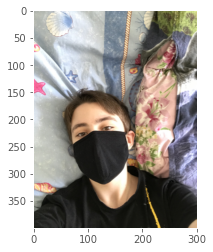

In [33]:
# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
        # determine the class label and color we'll use to draw
        # the bounding box and text
        if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
            label = 'with_mask'
            color = (0, 255, 0)
        elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
            label = 'without_mask'
            color = (0, 0, 255)
        else:
            label = 'mask_worn_incorrectly'
            color = (255, 140, 0)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
# source: https://stackoverflow.com/questions/38598118/difference-between-plt-show-and-cv2-imshow
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.grid(None)

In [ ]:
plt.imshow(image)

In [ ]:
print(startY,endY, startX,endX)

In [ ]:
print(startY,endY, startX,endX)